In [1]:
using Distributions, Plots, Plots.PlotMeasures, Random, RxInfer, StableRNGs

# Generative process

We have a generative process that, for any hidden state $x \in \mathbb{R}$, generates a random outcome according to

$$y \sim \mathcal{N}(g_{\mathcal{E}}(x, \mathbf{\beta}), \sigma_y^2)$$

where:

 - $\pmb{\beta} = [\beta_0, \beta_1]^\top$
 - $g_{\mathcal{E}}(x, \pmb{\beta}) = \beta_0 + \beta_1 x$ is the generating function for the generative process
 - for any $\mu$ and $\sigma^2$, $\mathcal{N}(\mu, \sigma^2)$ is the univariate Gaussian with mean $\mu$ and variance $\sigma^2$
 - $\sigma_y^2$ is a particular, fixed variance for the process

An equivalent formulation is:

$$y = g_{\mathcal{E}}(x, \pmb{\beta}) + \omega_y$$

where $\omega_y \sim \mathcal{N}(0, \sigma^2)$ is a zero-mean Gaussian noise term.

As in section 2.1 of the Fundamentals of Active Inference draft, we assume that there is a single, true, fixed latent state $x^{\ast}$

# Generative model

The above is written from the omniscient view of someone with access to the true state of the world. As mere agents, the true state is hidden from us. We seek to model and infer this state. Namely, we can establish a prior model $p(x)$ of the true state, an observation model $p(y|x)$ of observations conditional on state, and use the product rule from probability to construct the joint distribution over states and observations:

$$p(x, y) = p(y | x) p(x)$$

Pretending we didn't just formally define the generative process above, let's assume the agent uses prior knowledge somehow and "guesses" that a linear Gaussian observation model would work well:

$$p(y | x) = \mathcal{N}(y | g_{\mathcal{M}}(x, \mathbf{\gamma}), \eta_y^2)$$

where:

 - $\pmb{\gamma} = [\gamma_0, \gamma_1]^\top$
 - $g_{\mathcal{M}}(x, \pmb{\gamma}) = \gamma_0 + \gamma_1 x$ is our model of the process' generating function
 - $\eta_y^2$ is a fixed variance of the observation model

For the prior, we assume a Gaussian:

$$p(x) = \mathcal{N}(x | \mu_x, \sigma_x^2)$$

This modeling assumption reflects a belief that the hidden state is a continuous variable that can take on any real value $x \in (- \infty, + \infty)$. Different beliefs might lead us to different choice of prior (e.g. a log-normal prior for $x \in (0, \infty)$, or a categorical prior for a discrete $x$)

In [2]:
function make_gaussian(a, b, v, x, rng)
    num_samples = length(x)
    y = a .+ b * x .+ randn(rng, num_samples) * sqrt(v)
    return x, y
end


make_gaussian (generic function with 1 method)

In [3]:
seed = 299792458

rng = StableRNG(seed)

StableRNGs.LehmerRNG(state=0x00000000000000000000000023bcf095)

In [4]:
# example 2b from FOAI
function generative_process(rng, x)
    β = [3, 2]
    xs = [x]
    var_y = 1
    return make_gaussian(β[1], β[2], var_y, xs, rng)
end

x_hidden = 2
x_data, y_data = generative_process(rng, x_hidden)

([2], [7.635260638352808])

In [5]:
function generative_model_1(rng, ys)
    # assume we've already learned the correct parameters, somehow
    γ = [3, 2]
    g_M = x -> γ[1] + γ[2] * x
    stddev_y = sqrt(0.25)
    mu_x = 4
    stddev_x = sqrt(0.25)

    prior = Normal(mu_x, stddev_x)
    likelihood = x -> Normal(g_M(x), stddev_y)
    
    xs = range(0, 6, length = 1000)

    plot!(xs, (x) -> pdf.(prior, x), fillalpha=0.3, fillrange=0, label="p(x)", c=1)
    plot!(xs, (x) -> pdf.(likelihood(x), ys[1]), fillalpha=0.3, fillrange=0, label="p(y|x)", c=2)

    model_expr = :(@model function model_1(n, mu_x, stddev_x, γ, stddev_y)
        y = datavar(Float64, n)
        x ~ NormalMeanVariance(mu_x, stddev_x)
    
        for i in 1:n
            y[i] ~ NormalMeanVariance(γ[1] + γ[2] * x, stddev_y)
        end
    end)

    eval(model_expr)

    result = infer(
        model = model_1(length(ys), mu_x, stddev_x, γ, stddev_y), 
        data  = (y = ys, ),
        free_energy  = true
    )

    posterior = result.posteriors[:x]

    plot!(xs, (x) -> pdf(posterior, x), fillalpha=0.3, fillrange = 0, label="p(x|y)", c=3)

end

generative_model_1 (generic function with 1 method)

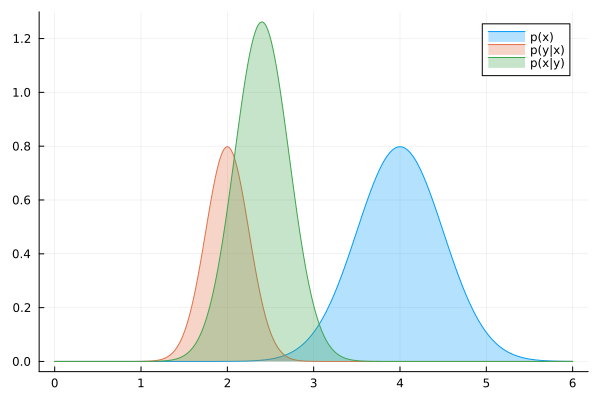

In [45]:
plot()
generative_model_1(rng, [7.0])
#vline!(x_data, label="x", c=4)